```plaintext
To be done: function for measurements and plots

Long road, Two lanes, Different Vmax 
Add car when start point is empty 
Remove car at end point 

Ordered Rules:
1. Change lane
2. Change speed
    ·Accelerate
    ·Slow down
    ·Random brake
    ·
3. Move

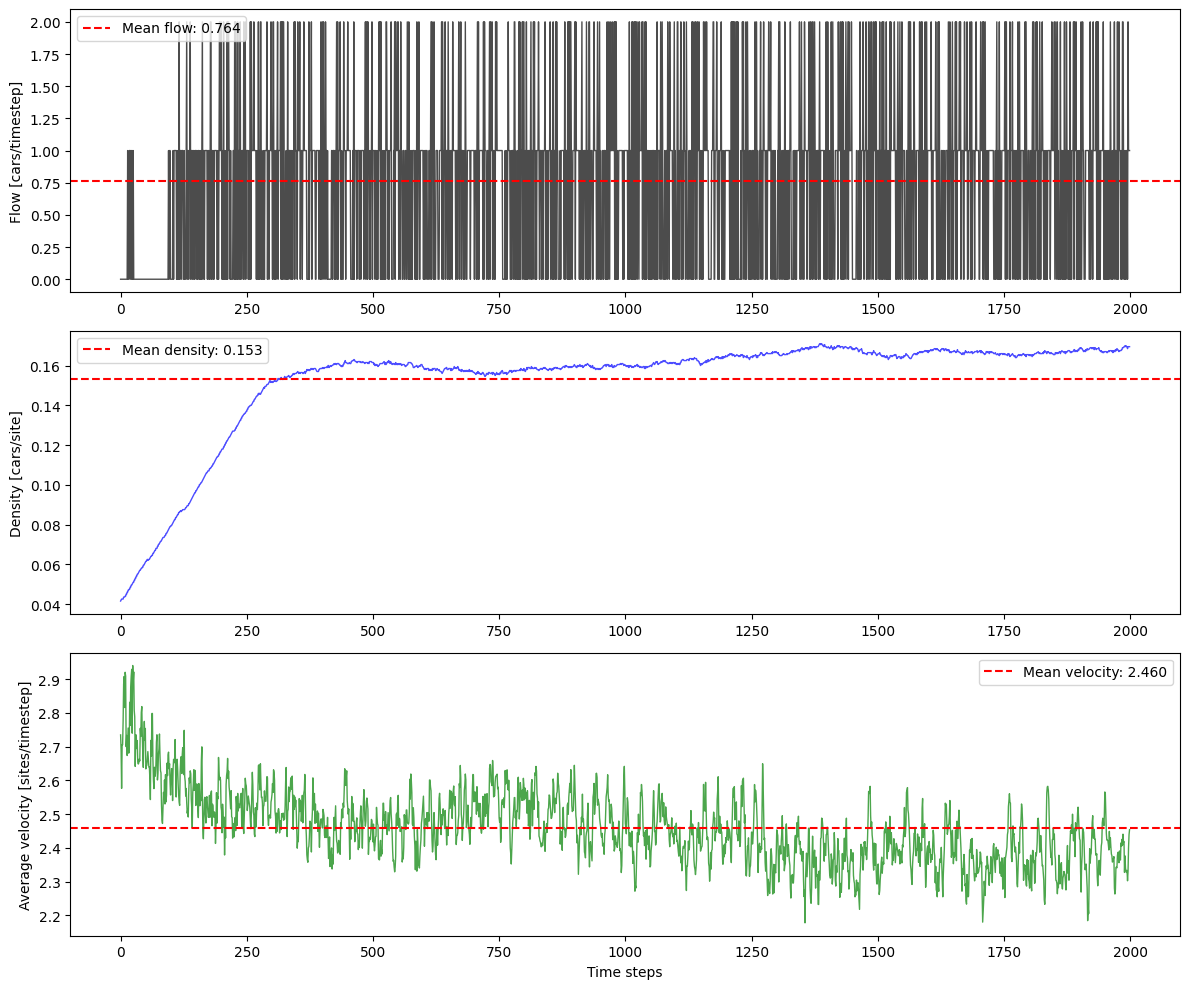

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# dict to store different driver type(can also be used for reaction/...)
DRIVER_TYPES = {
    0: {'vmax': 3},    
    1: {'vmax': 5},      
    2: {'vmax': 7}   
}

# initialize the road
def initialize_road(length):
    lanes = [np.full(length, -1), np.full(length, -1)]  
    # store driver type for each car
    driver_types = [np.full(length, -1), np.full(length, -1)]  
    return lanes, driver_types

# get the gap 
def get_gap_ahead_same_lane(lane, pos):
    length = len(lane)
    
    # check if the current position is valid
    if pos < 0 or pos >= length:
        raise ValueError("Current position is out of range")
    
    # check if there is a car at the current position
    if lane[pos] == -1:
        raise ValueError("There is no car at the current position")
    
    gap = 0
    for i in range(1, length - pos):  # we only have to check sites after pos
        next_pos = pos + i
        
        if lane[next_pos] >= 0:
            return gap
        gap += 1
    return gap

# get forward and backward gaps for other lane
def get_gaps_other_lane(lanes, lane_idx, pos):
    other_lane = lanes[1 - lane_idx]
    length = len(other_lane)
    
    # Forward
    forward_gap = 0
    for i in range(1, length - pos): 
        next_pos = pos + i
        if other_lane[next_pos] >= 0:
            break
        forward_gap += 1
        
    # Backward
    backward_gap = 0    
    for i in range(1, pos + 1): # we only have to check sites between pos and start point
        prev_pos = pos - i
        if other_lane[prev_pos] >= 0:
            break
        forward_gap += 1
        
    return forward_gap, backward_gap

# check whether should change the lane
def should_change_lane(lanes, lane_idx, pos, driver_types, p_change):

    if lanes[lane_idx][pos] == -1:
        return False
    
    driver_type = driver_types[lane_idx][pos]
    if driver_type == -1:
        return False

    gap = get_gap_ahead_same_lane(lanes[lane_idx], pos)
    v = lanes[lane_idx][pos]
    
    # T1: Check if blocked
    if gap >= v + 1:
        return False
    
    # T2 & T3: Check if other lane has enough space
    gap_front, gap_back = get_gaps_other_lane(lanes, lane_idx, pos)
    if gap_front <= v + 1 or gap_back < 7:
        return False
    
    # T4: Random decision
    if np.random.random() >= p_change:
        return False
    
    return True

# updatge change of lane
def change_lanes(lanes, driver_types, p_change):
    length = len(lanes[0])
    changes = []
    
    # record the index and position that would change lane
    for lane_idx in range(2):
        for pos in range(length):
            if should_change_lane(lanes, lane_idx, pos, driver_types, p_change):
                changes.append((lane_idx, pos))
                
    # change lane
    for lane_idx, pos in changes:
        if lanes[lane_idx][pos] >= 0:
            # get velocity and driver type
            v = lanes[lane_idx][pos]
            driver_type = driver_types[lane_idx][pos]
            
            # change lane
            lanes[lane_idx][pos] = -1
            driver_types[lane_idx][pos] = -1
            
            lanes[1-lane_idx][pos] = v
            driver_types[1-lane_idx][pos] = driver_type
    
    return lanes, driver_types

# update velocities for each step
def update_velocities(lanes, driver_types, p):
    for lane_idx in range(2):
        for pos in range(len(lanes[0])):
            if lanes[lane_idx][pos] >= 0:
                driver_type = driver_types[lane_idx][pos]

                vmax = DRIVER_TYPES[driver_type]['vmax']
                v = lanes[lane_idx][pos]
                
                # Acceleration
                if v < vmax:
                    v += 1
                
                # Slowing down
                gap = get_gap_ahead_same_lane(lanes[lane_idx], pos)
                v = min(v, gap)
                
                # Slowing down
                if v > 0 and np.random.random() < p:
                    v -= 1
                
                lanes[lane_idx][pos] = v
    
    return lanes

# move cars after get velocity
def move_cars(lanes, driver_types):
    length = len(lanes[0])
    new_lanes = [np.full(length, -1), np.full(length, -1)]
    new_driver_types = [np.full(length, -1), np.full(length, -1)]
    
    for lane_idx in range(2):
        for pos in range(length):
            if lanes[lane_idx][pos] >= 0:
                v = lanes[lane_idx][pos]
                new_pos = pos + v
                
                if new_pos < length:
                    new_lanes[lane_idx][new_pos] = v
                    new_driver_types[lane_idx][new_pos] = driver_types[lane_idx][pos]
    
    return new_lanes, new_driver_types

# add car when start point is empty
def add_new_car(lanes, driver_types):
    for lane_idx in range(2):
        # add car if the start point is empty
        if lanes[lane_idx][0] == -1:
            lanes[lane_idx][0] = 0  
            new_driver_type = np.random.randint(0, len(DRIVER_TYPES))
            driver_types[lane_idx][0] = new_driver_type
    return lanes, driver_types

# remove car when it reach end point
def remove_cars(lanes, driver_types, exit_point):
    # remove the car when it reach end point
    for lane_idx in range(2):
        lanes[lane_idx][exit_point:] = -1
        driver_types[lane_idx][exit_point:] = -1
    return lanes, driver_types

# code for update traffic for each step
def update_traffic(lanes, driver_types, exit_point, p=0.3, p_change=0.3):
    # change lane
    lanes, driver_types = change_lanes(lanes, driver_types, p_change)
    
    # update velocities
    lanes = update_velocities(lanes, driver_types, p)
    
    # move cars
    lanes, driver_types = move_cars(lanes, driver_types)
    
    # remove cars that reach end point
    lanes, driver_types = remove_cars(lanes, driver_types, exit_point)
    
    # add new car at start point
    lanes, driver_types = add_new_car(lanes, driver_types)
    
    return lanes, driver_types

# code for calculate traffic measurements
def calculate_traffic_measurements(lanes):
    length = len(lanes[0])
    measure_point = length // 2
    total_flow = 0
    num_cars = 0
    total_velocity = 0
    
    for lane_idx in range(2):
        car_positions = np.where(lanes[lane_idx] >= 0)[0]
        car_velocities = lanes[lane_idx][car_positions]
        
        num_cars += len(car_positions)
        total_velocity += np.sum(car_velocities)
        
        
        for pos in car_positions:
            velocity = lanes[lane_idx][pos]
            if velocity > 0:
                start_pos = pos - velocity
                
                if start_pos <= measure_point < pos:
                    total_flow += 1
    
    density = num_cars / (2 * length)  
    avg_velocity = total_velocity / num_cars
    
    return total_flow, density, avg_velocity
# run the simulation
def simulate_traffic(length, t0, steps, p=0.3, p_change=0.3):
    lanes, driver_types = initialize_road(length)
    exit_point = length - 10
    
    # first simulate t0 times, and begin the collection of data after the first t0 time steps
    for _ in range(t0):
        lanes, driver_types = update_traffic(lanes, driver_types, exit_point, p, p_change)
        
    
    flows = []
    densities = []
    velocities = []
    
    lanes_history = np.zeros((steps, 2, length), dtype=int)
    driver_types_history = np.zeros((steps, 2, length), dtype=int)
    
    lanes_history[0] = lanes
    driver_types_history[0] = driver_types
    
    # simulate and start to record the data
    for step in range(steps):
        flow, density, velocity = calculate_traffic_measurements(lanes)
        flows.append(flow)
        densities.append(density)
        velocities.append(velocity)
        
        lanes, driver_types = update_traffic(lanes, driver_types, exit_point, p, p_change)
        if step < steps - 1:
            lanes_history[step + 1] = lanes
            driver_types_history[step + 1] = driver_types

    return flows, densities, velocities, lanes_history, driver_types_history

# just rough plot for the measurements
def plot_traffic_measurements(flows, densities, velocities, steps):
    time = np.arange(steps)
    

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    

    ax1.plot(time, flows, 'k-', linewidth=1, alpha=0.7)
    ax1.axhline(y=np.mean(flows), color='r', linestyle='--', 
                label=f'Mean flow: {np.mean(flows):.3f}')
    ax1.set_ylabel('Flow [cars/timestep]')
    ax1.legend()
    

    ax2.plot(time, densities, 'b-', linewidth=1, alpha=0.7)
    ax2.axhline(y=np.mean(densities), color='r', linestyle='--',
                label=f'Mean density: {np.mean(densities):.3f}')
    ax2.set_ylabel('Density [cars/site]')
    ax2.legend()
    

    ax3.plot(time, velocities, 'g-', linewidth=1, alpha=0.7)
    ax3.axhline(y=np.mean(velocities), color='r', linestyle='--',
                label=f'Mean velocity: {np.mean(velocities):.3f}')
    ax3.set_ylabel('Average velocity [sites/timestep]')
    ax3.set_xlabel('Time steps')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

flows, densities, velocities, lanes_history, driver_types_history = simulate_traffic(1000, 100, 2000, p=0.3, p_change=0.3)
plot_traffic_measurements(flows, densities, velocities, 2000)